# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 5: Minería de textos

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 29 de agosto de 2024


### 🚨 Se puede descargar manualmente el dataset mediante el enlace de abajo o ejecutando el código proporcionado. (Es necesario una cuenta y una key de kaggle). Es importante descomprimir el archivo en la carpeta data.

nltk, spacy, textblob

In [89]:
import os
import opendatasets as od
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from collections import Counter
import seaborn as sns
from matplotlib_venn import venn2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 📂 Funciones utilitarias

In [90]:
def printText(df, stop = 10):
    for i, t in enumerate(df):
        print(i, t)
        if i >= stop:
            break

### 📩 Inciso 1. Descargar el archivo train.csv

In [91]:
if not os.path.isdir('nlp-getting-started'):
    od.download("https://www.kaggle.com/c/nlp-getting-started/data")

### 📩 Inciso 2. Carga de los datos

In [92]:
dataTrain = pd.read_csv('nlp-getting-started/train.csv')
dataTest = pd.read_csv('nlp-getting-started/test.csv')
dataSampleSubmission = pd.read_csv('nlp-getting-started/sample_submission.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [93]:
dataTrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [94]:
dataTrain.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [95]:
for i, element in enumerate(dataTrain.columns):
    print(str(i+1)+")📚["+element+"].Count:", dataTrain[element].count())

1)📚[id].Count: 7613
2)📚[keyword].Count: 7552
3)📚[location].Count: 5080
4)📚[text].Count: 7613
5)📚[target].Count: 7613


In [96]:
text = dataTrain['text']

#### 🖼️ Removiendo urls

In [97]:
textWithoutUrl = text.str.replace(r'http\S+|www\S+', '', regex=True)
printText(textWithoutUrl, 100)

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...
10 Three people died from the heat wave so far
11 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
12

#### 🔡 Convertir a minúsculas. 

In [98]:
textLowerCase = textWithoutUrl.str.lower()
textLowerCase.head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

#### 🤔 Removiendo caracteres especiales (@/#/')

In [99]:

textWithouthSpecialCharacthers = textLowerCase.str.replace('@', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('#', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace("'", "")
textWithouthSpecialCharacthers.head()

0    our deeds are the reason of this earthquake ma...
1               forest fire near la ronge sask. canada
2    all residents asked to shelter in place are be...
3    13,000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 👾 Removiendo patrones extraños

In [100]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\?+', '?', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\!+', '!', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('&amp;', 'and')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('\n', ' ')
printText(textWithouthSpecialCharacthers, stop=20)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask. canada
2 all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected
3 13,000 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy. 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas
7 im on top of the hill and i can see a fire in the woods...
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area...
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodi

#### 📚 Reduciendo la cantidad de letras repetidas

In [101]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(\.{3,})', 'THREEPOINTSIDENFIFIER', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(.)\1{'+str(2)+',}', r'\1' * 2, regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('THREEPOINTSIDENFIFIER', '...')
textWithouthSpecialCharacthers

0       our deeds are the reason of this earthquake ma...
1                  forest fire near la ronge sask. canada
2       all residents asked to shelter in place are be...
3       13,00 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610          m1.94 [01:04 utc]?5km s of volcano hawaii. 
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

#### 🛹 Quintando puntos y comas.

In [102]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('.',' ')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(',',' ')
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask  canada
2 all residents asked to shelter in place are being notified by officers  no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy  20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou  colorado springs areas
7 im on top of the hill and i can see a fire in the woods   
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area   
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodin

#### 🧹 Removiendo varios espacios en blanco y dejando solo uno

In [103]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\s{2,}', ' ', regex=True)
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask canada
2 all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7 im on top of the hill and i can see a fire in the woods 
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area 
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining flooding florid

#### 🧹 Removiendo stopwords    

In [104]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def removeStopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopWords]  
    return ' '.join(filtered_words)

textWithoutStopwords = textWithouthSpecialCharacthers.apply(removeStopwords)
printText(textWithoutStopwords, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 13 00 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy 20 closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa 18 19 days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus 80 multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 lov

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
textWithoutStopwords = textWithoutStopwords.str.replace(r'[^\w\s]','',regex=True)

### Inciso 4. 🖼️ Frecuencia de palabras

In [106]:
nltk.download('punkt_tab')
tokenizedText = textWithoutStopwords.apply(word_tokenize)
allWords = [word for words in tokenizedText for word in words]
wordCounts = Counter(allWords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       Word  Frequency
133    like        346
59       im        302
8      fire        252
234     get        229
164     new        224
781     via        220
25   people        196
748    news        194
356    dont        192
627     one        192


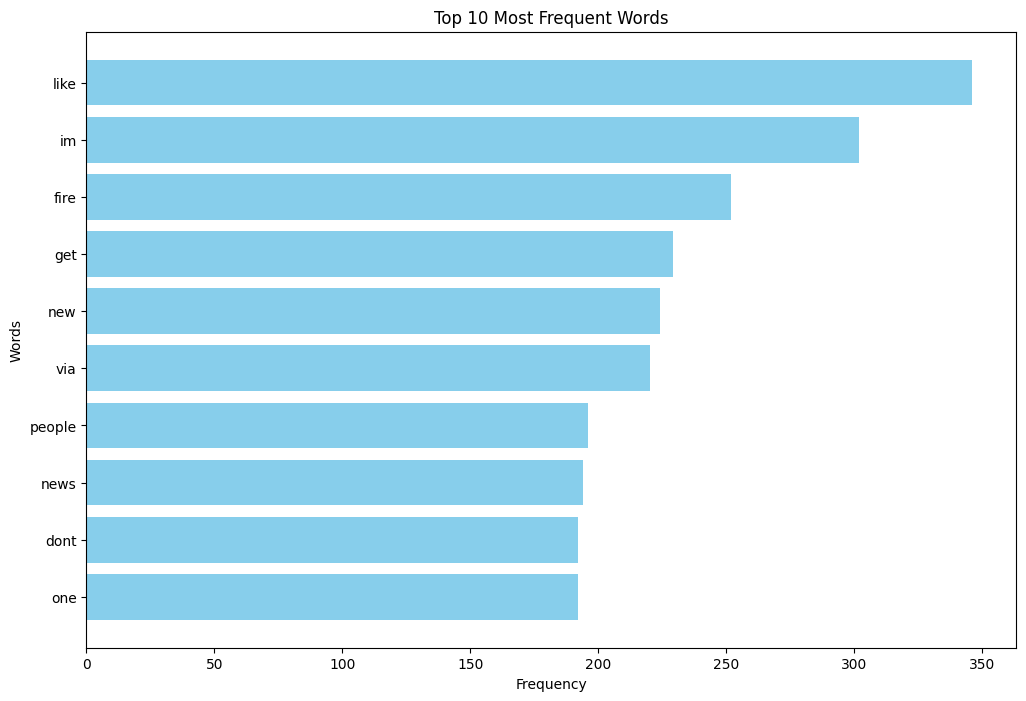

In [107]:
wordFreqDf = pd.DataFrame(wordCounts.items(), columns=['Word', 'Frequency'])
wordFreqDf = wordFreqDf.sort_values(by='Frequency', ascending=False)
print(wordFreqDf.head(10))
plt.figure(figsize=(12, 8))
plt.barh(wordFreqDf['Word'].head(10), wordFreqDf['Frequency'].head(10), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis() 
plt.show()

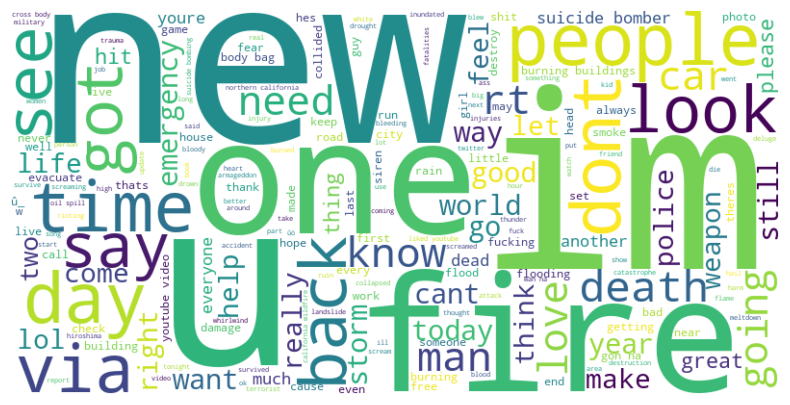

In [108]:
completeText = ' '.join(allWords)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(completeText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

🔄 Generando 2-gramas...
📈 Mostrando los 10 2-gramas más frecuentes:
Label                   Disasters  No Disasters
2-gram                                         
(burning, buildings)         35.0          23.0
(california, wildfire)       34.0           NaN
(cross, body)                 1.0          38.0
(gon, na)                    11.0          32.0
(liked, youtube)              7.0          35.0
(northern, california)       41.0           NaN
(oil, spill)                 38.0           1.0
(suicide, bomber)            59.0           NaN
(wan, na)                     5.0          30.0
(youtube, video)              7.0          36.0


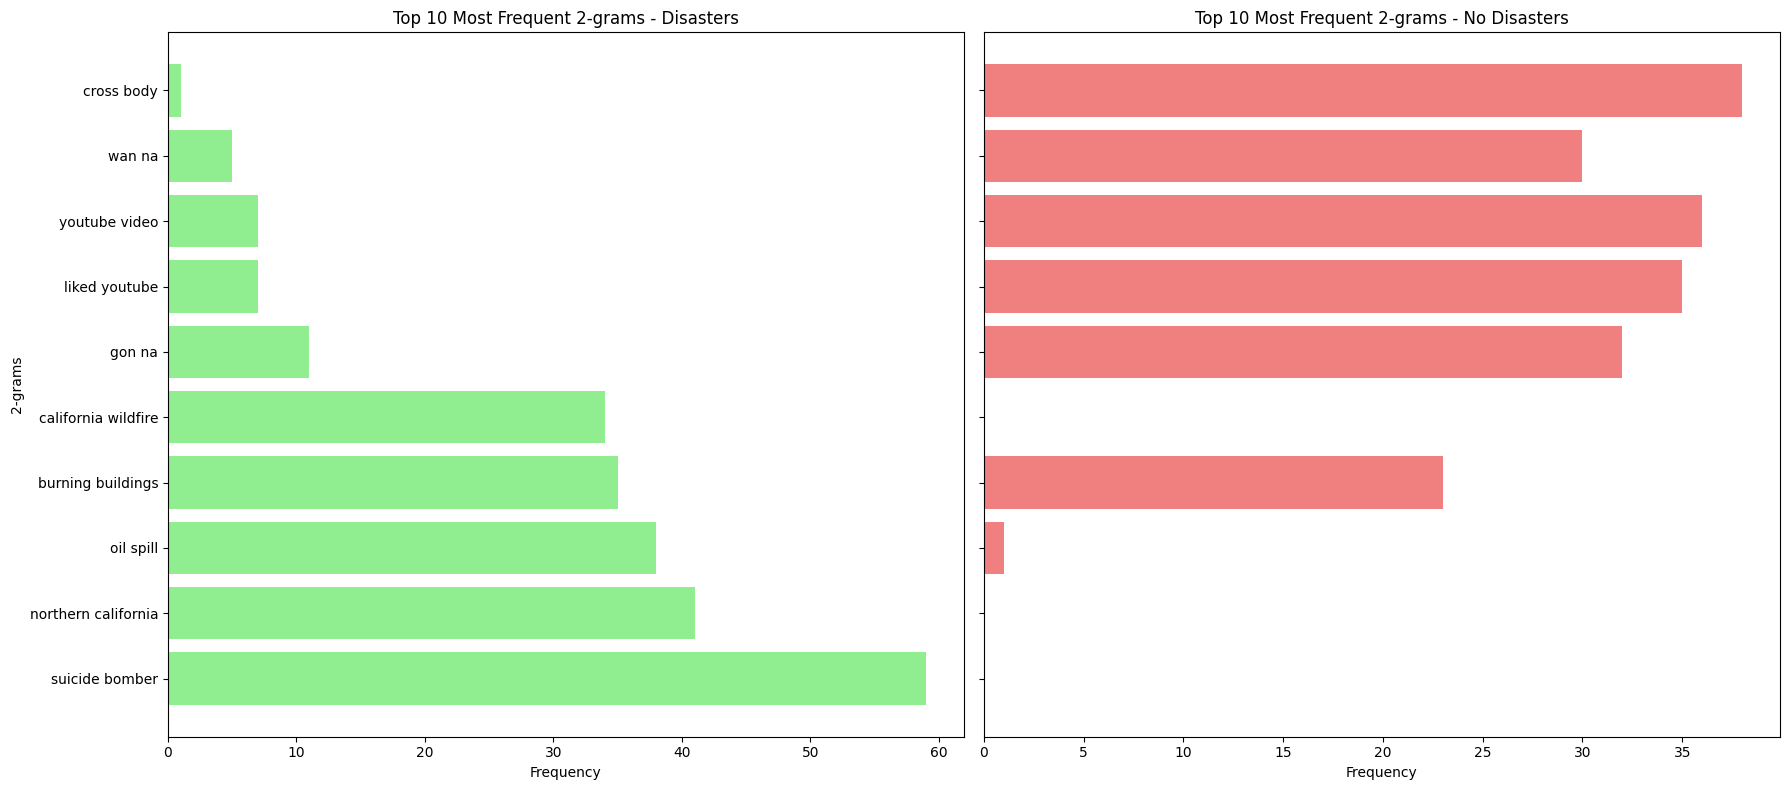

✅ Gráficos de 2-gramas generados.
🔄 Generando 3-gramas...
📈 Mostrando los 10 3-gramas más frecuentes:
Label                             Disasters  No Disasters
3-gram                                                   
(16yr, old, pkk)                       27.0           NaN
(bomber, detonated, bomb)              28.0           NaN
(homes, razed, northern)               28.0           NaN
(latest, homes, razed)                 28.0           NaN
(liked, youtube, video)                 7.0          35.0
(northern, california, wildfire)       29.0           NaN
(old, pkk, suicide)                    27.0           NaN
(pkk, suicide, bomber)                 28.0           NaN
(razed, northern, california)          27.0           NaN
(suicide, bomber, detonated)           30.0           NaN


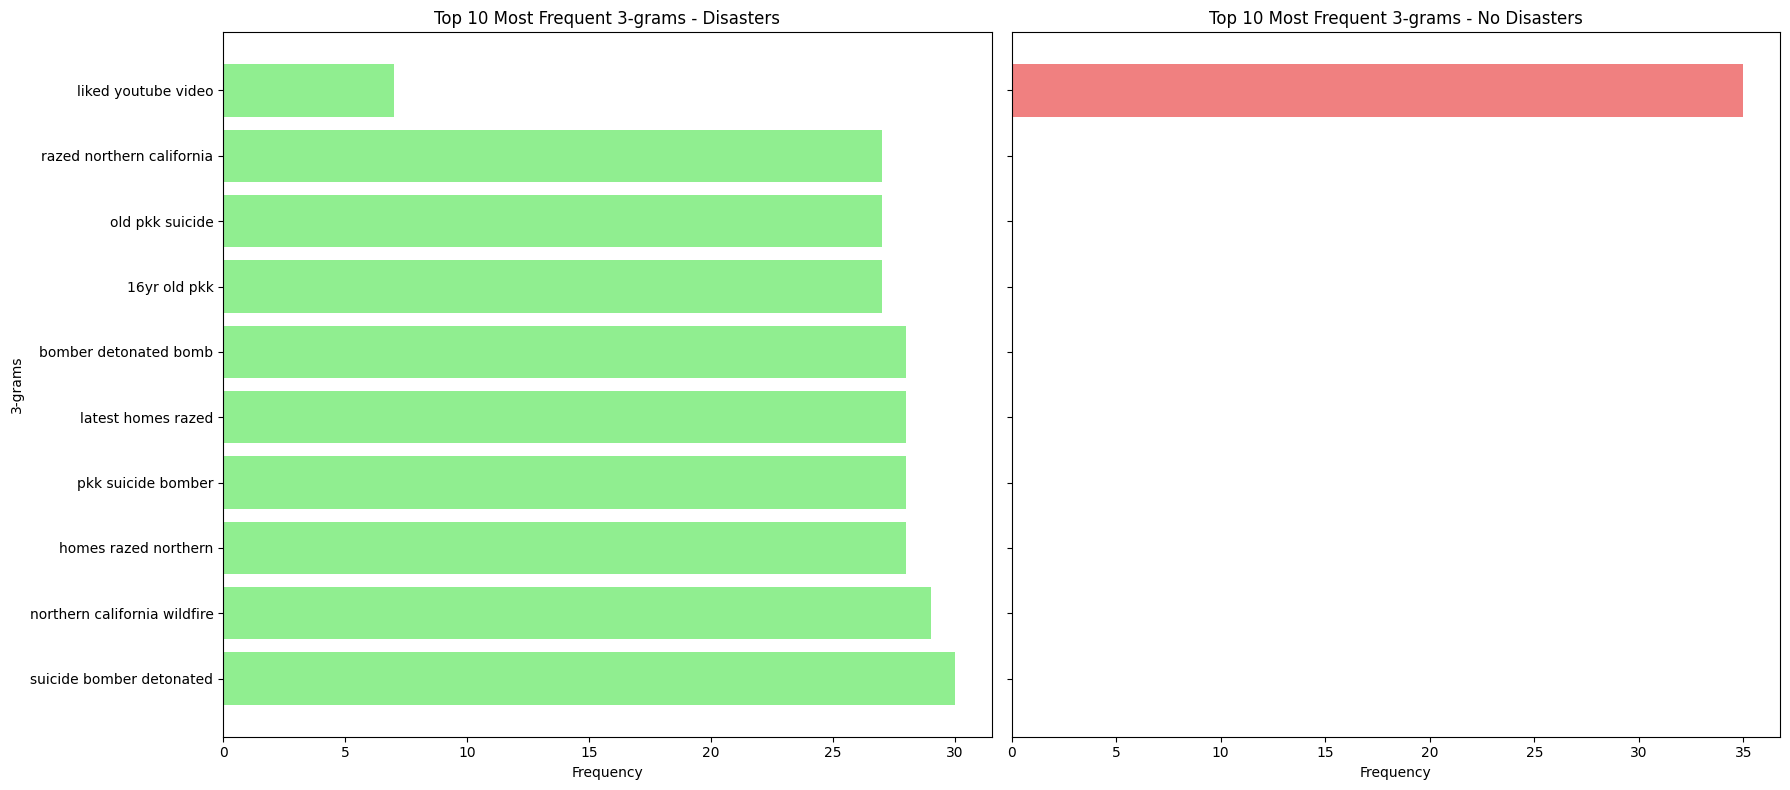

✅ Gráficos de 3-gramas generados.


In [109]:
def ngramAnalysis(tokenizedTextColumn, targetColumn, n=2):
    print(f"🔄 Generando {n}-gramas...")

    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def analyzeNgrams(texts, label):
        ngramsList = [ngram for tokens in texts for ngram in ngrams(tokens, n)]
        ngramCounts = Counter(ngramsList)
        ngramFreqDf = pd.DataFrame(ngramCounts.items(), columns=[f'{n}-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
        ngramFreqDf['Label'] = label
        return ngramFreqDf
    
    disasterNgramsDf = analyzeNgrams(disasterTweets, 'Disasters')
    nonDisasterNgramsDf = analyzeNgrams(nonDisasterTweets, 'No Disasters')
    
    topNgrams = pd.concat([disasterNgramsDf, nonDisasterNgramsDf]).groupby([f'{n}-gram'])['Frequency'].sum().sort_values(ascending=False).head(10).index
    topNgramsDf = pd.concat([disasterNgramsDf, nonDisasterNgramsDf])
    topNgramsDf = topNgramsDf[topNgramsDf[f'{n}-gram'].isin(topNgrams)]

    print(f"📈 Mostrando los 10 {n}-gramas más frecuentes:")
    print(topNgramsDf.groupby([f'{n}-gram', 'Label'])['Frequency'].sum().unstack())


    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    

    disasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Disasters']
    axs[0].barh([' '.join(ngram) for ngram in disasterSubset[f'{n}-gram']], disasterSubset['Frequency'], color='lightgreen')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel(f'{n}-grams')
    axs[0].set_title(f'Top 10 Most Frequent {n}-grams - Disasters')
    axs[0].invert_yaxis()
    
    nonDisasterSubset = topNgramsDf[topNgramsDf['Label'] == 'No Disasters']
    axs[1].barh([' '.join(ngram) for ngram in nonDisasterSubset[f'{n}-gram']], nonDisasterSubset['Frequency'], color='lightcoral')
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top 10 Most Frequent {n}-grams - No Disasters')
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print(f"✅ Gráficos de {n}-gramas generados.")

ngramAnalysis(tokenizedText, dataTrain['target'], n=2)
ngramAnalysis(tokenizedText, dataTrain['target'], n=3)

### 📚 Inciso 5. Análisis exploratorio

#### ✖️ Palabra más repetidas

In [110]:
def mostFrequentWords(tokenizedTextColumn, targetColumn):
    print("🔄 Analizando palabras más frecuentes por categoría...")
    
    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def countWords(texts):
        wordsList = [word for tokens in texts for word in tokens]
        wordCounts = Counter(wordsList)
        return wordCounts
    
    disasterWordCounts = countWords(disasterTweets)
    nonDisasterWordCounts = countWords(nonDisasterTweets)
    disasterWordFreqDf = pd.DataFrame(disasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    nonDisasterWordFreqDf = pd.DataFrame(nonDisasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    print("📈 Palabra más frecuente en desastres:")
    print(disasterWordFreqDf.head(1))
    
    print("📈 Palabra más frecuente en no desastres:")
    print(nonDisasterWordFreqDf.head(1))
    
    return disasterWordFreqDf, nonDisasterWordFreqDf

disasterWordFreqDf, nonDisasterWordFreqDf = mostFrequentWords(tokenizedText, dataTrain['target'])

🔄 Analizando palabras más frecuentes por categoría...
📈 Palabra más frecuente en desastres:
   Word  Frequency
8  fire        180
📈 Palabra más frecuente en no desastres:
    Word  Frequency
24  like        253


#### ☁️ Nube de las palabras más frecuentes

🌐 Generando nube de palabras para Desastres...


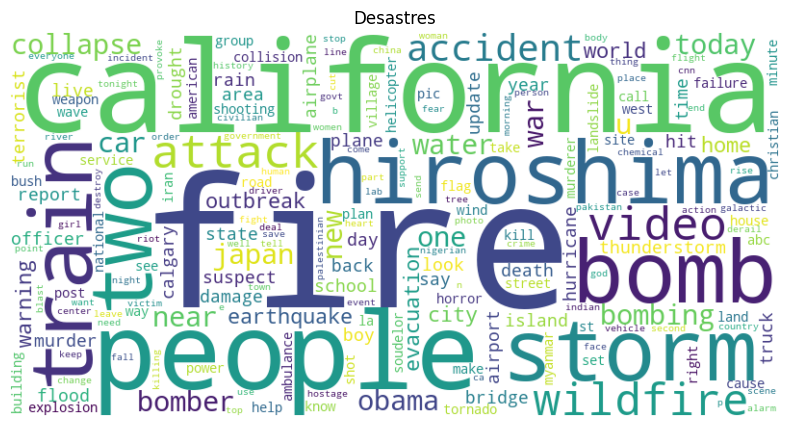

✅ Nube de palabras para Desastres generada.
🌐 Generando nube de palabras para No Desastres...


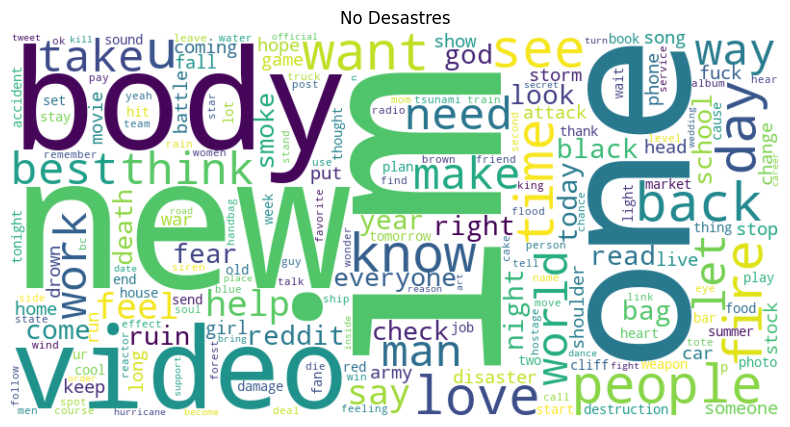

✅ Nube de palabras para No Desastres generada.


In [111]:
def plotWordCloud(wordFreqDf, title):
    print(f"🌐 Generando nube de palabras para {title}...")
    text = ' '.join(wordFreqDf['Word'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    print(f"✅ Nube de palabras para {title} generada.")

plotWordCloud(disasterWordFreqDf, 'Desastres')
plotWordCloud(nonDisasterWordFreqDf, 'No Desastres')

#### 📊 Histogramas con las palabras más repetidas

📊 Generando histograma de palabras más frecuentes para Desastres...


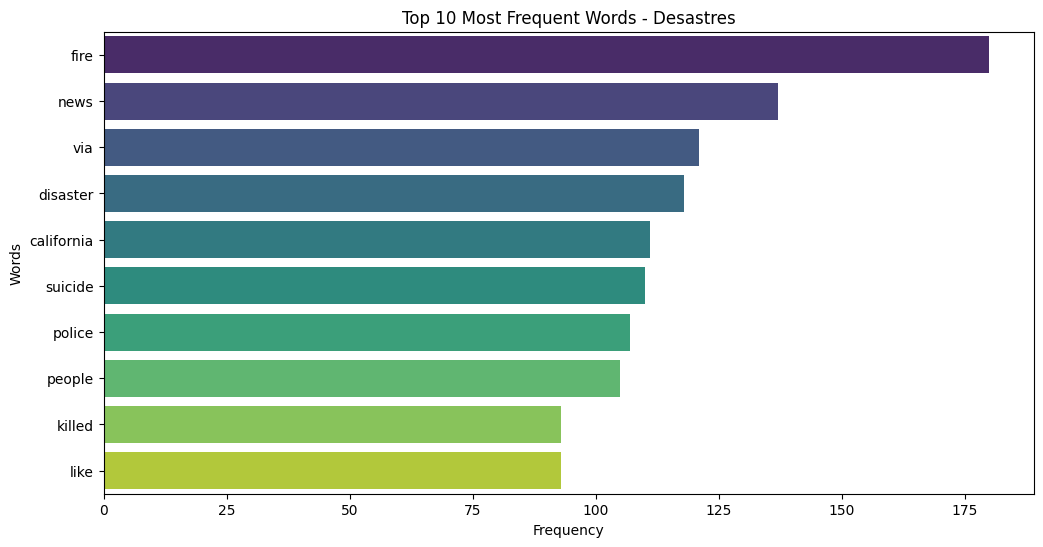

✅ Histograma de palabras más frecuentes para Desastres generado.
📊 Generando histograma de palabras más frecuentes para No Desastres...


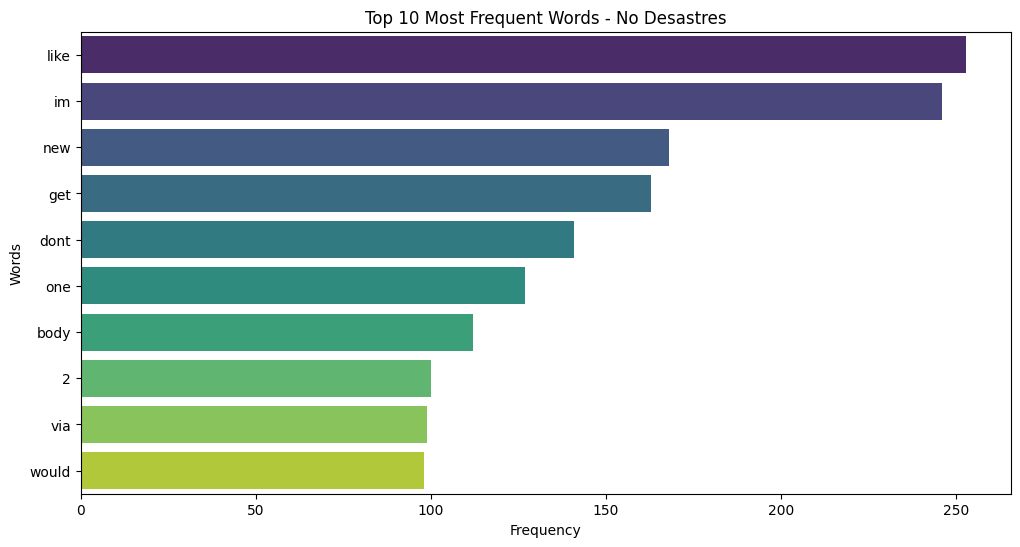

✅ Histograma de palabras más frecuentes para No Desastres generado.


In [112]:
def plotTopWordsHistogram(wordFreqDf, title):
    print(f"📊 Generando histograma de palabras más frecuentes para {title}...")
    topWords = wordFreqDf.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=topWords, hue='Word', palette='viridis', legend=False)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 10 Most Frequent Words - {title}')
    plt.show()
    
    print(f"✅ Histograma de palabras más frecuentes para {title} generado.")

plotTopWordsHistogram(disasterWordFreqDf, 'Desastres')
plotTopWordsHistogram(nonDisasterWordFreqDf, 'No Desastres')


🔍 Identificando palabras comunes en ambas categorías...
📚 Palabras comunes en ambas categorías:
{'hailstorm', 'lane', 'happens', 'triggered', 'posted', 'gilbert23', 'sis', 'ban', 'cook', 'tooth', 'yall', 'tell', 'lightning', 'sinking', 'salem', 'gems', 'multiple', 'forbes', '99', 'goes', 'hiphop', 'multidimensi', 'acting', 'director', 'banned', '4wd', 'familia', 'industry', 'logic', 'ay', 'finger', 'mill', 'mess', 'gotten', 'japan', 'camping', 'charger', 'chairman', 'panicking', 'amongst', 'nc', 'cain', 'personal', 'drunk', 'city', 'wars', 'hit', 'raised', 'year', 'mariah', 'rifles', 'thus', 'kings', 'millions', 'stranded', 'suspected', 'motor', 'thats', 'bomber', 'mentions', 'hostages', 'score', 'farm', 'united', 'caused', 'not', 'network', 'avenue', 'may', 'pics', 'utter', 'reading', 'prophet', 'apartment', 'scotland', 'photo', 'sunset', 'tape', 'premium', 'rt_america', 'guy', 'brazil', 'young', 'warn', 'bombed', 'russia', 'violence', 'uk', 'officers', 'accident', 'improve', 'part', 

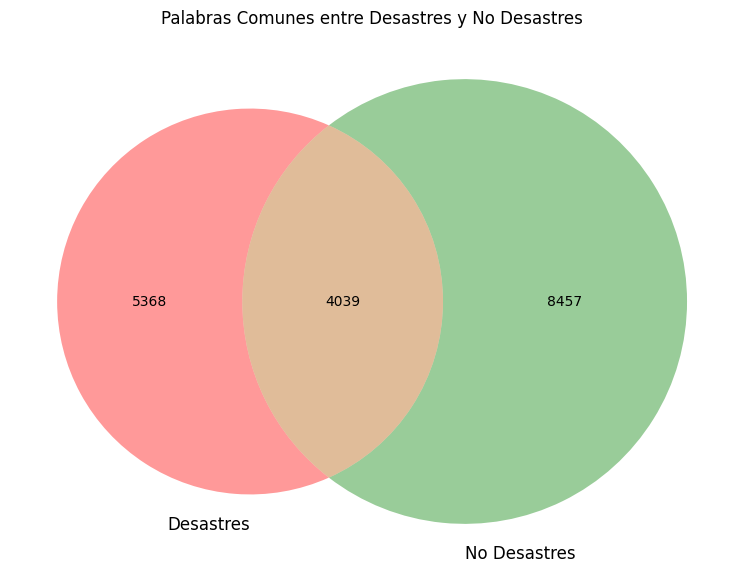

In [113]:
def commonWords(disasterWordFreqDf, nonDisasterWordFreqDf):
    print("🔍 Identificando palabras comunes en ambas categorías...")
    disasterWords = set(disasterWordFreqDf['Word'])
    nonDisasterWords = set(nonDisasterWordFreqDf['Word'])
    commonWords = disasterWords.intersection(nonDisasterWords)
    print("📚 Palabras comunes en ambas categorías:")
    print(commonWords)
    plt.figure(figsize=(10, 7))
    venn = venn2([disasterWords, nonDisasterWords], ('Desastres', 'No Desastres'))
    plt.title('Palabras Comunes entre Desastres y No Desastres')
    plt.show()

commonWords(disasterWordFreqDf, nonDisasterWordFreqDf)

### 🧠 Inciso 6. Modelos

#### 🗂️ Dividir en entrenamiento y prueba (80 - 20).

In [114]:
sentences = textWithoutStopwords.tolist()
targets = dataTrain['target'].tolist()
testSentences= dataTest['text'].tolist()

trainingSize = int(len(sentences) * 0.80)
trainingSentences = sentences[0:trainingSize]
testingSentences = sentences[trainingSize:]
trainingTargets = targets[0:trainingSize]
testingTargets = targets[trainingSize:]

trainingTargetsArray = np.array(trainingTargets)
testingTargetsArray = np.array(testingTargets)

print(trainingTargetsArray)
print(testingTargetsArray)

[1 1 1 ... 0 0 0]
[0 1 0 ... 1 1 1]


#### 🖼️ Tokenización y aplicación de padding.

In [115]:
tokenizer = Tokenizer(num_words = 500, oov_token='<OOV>')
tokenizer.fit_on_texts(trainingSentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testingSentences)
testing_padded = pad_sequences(testing_sequences, maxlen=40, padding='post', truncating='post')
main_test_sequence=tokenizer.texts_to_sequences(testSentences)
main_test_padded=pad_sequences(main_test_sequence,maxlen=40,padding='post',truncating='post')

In [116]:
def add_embedding_noise(embedding, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(embedding), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    return embedding + noise

#### 🧠 LSTM y Embedding

In [117]:
firstModel = tf.keras.Sequential([
    layers.Embedding(500, 16, input_length=40),
    layers.Lambda(lambda x: add_embedding_noise(x, noise_factor=0.05)),
    layers.Bidirectional(layers.LSTM(8, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(8)),
    layers.Dense(72, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(36, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])


learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

firstModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
firstModel.summary()
firstModel.save('models/firstModel.h5')

c:\Users\lijv1.LINDA_HP\Documents\GitHub\Lab05_DSTC\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [118]:
earlyStopping=EarlyStopping(min_delta=0.001,patience=10)

In [119]:
history=firstModel.fit(
    training_padded,
    trainingTargetsArray,
    epochs=15,
    validation_data=(testing_padded,testingTargetsArray),
    callbacks=[earlyStopping]
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5193 - loss: 0.9293 - val_accuracy: 0.5345 - val_loss: 0.7548
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6117 - loss: 0.7589 - val_accuracy: 0.5785 - val_loss: 0.7171
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7172 - loss: 0.6240 - val_accuracy: 0.6257 - val_loss: 0.6918
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7536 - loss: 0.5657 - val_accuracy: 0.6802 - val_loss: 0.6367
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7593 - loss: 0.5623 - val_accuracy: 0.6861 - val_loss: 0.6447
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7737 - loss: 0.5376 - val_accuracy: 0.7163 - val_loss: 0.6012
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7785 - loss: 0.5309 - val_accuracy: 0.7045 - val_loss: 0.5911
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7956 - loss: 0.5123 - val_acc

In [120]:
loss, accuracy = firstModel.evaluate(testing_padded, testingTargetsArray)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6823 - loss: 0.6865
Test Loss: 0.6893
Test Accuracy: 0.6822


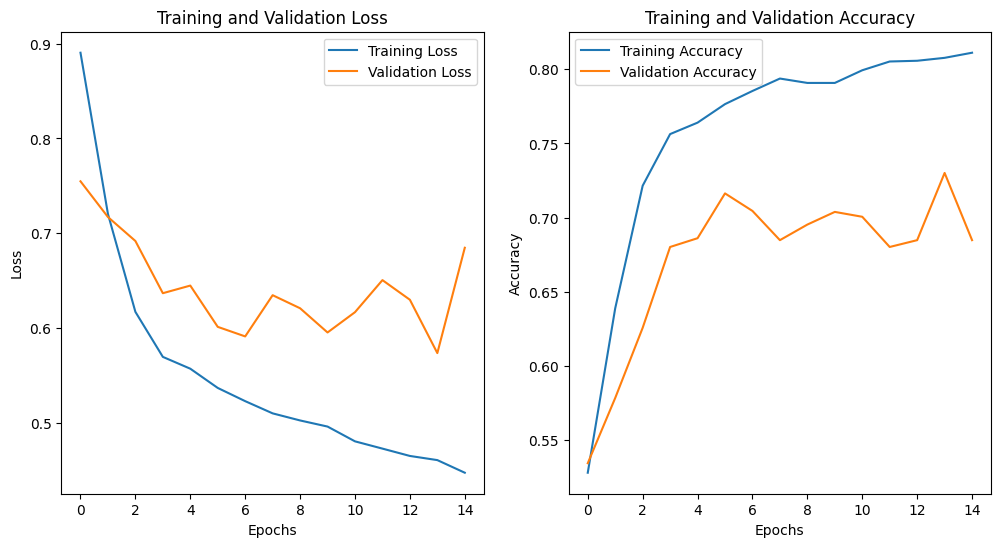

In [121]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2) # Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 🧠 CNN

In [122]:
secondModel = tf.keras.Sequential([
    layers.Embedding(500, 16, input_length=40),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
secondModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
secondModel.summary()
secondModel.save('models/secondModel.h5')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [123]:
earlyStopping = EarlyStopping(min_delta=0.001, patience=10)

In [124]:
history = secondModel.fit(
    training_padded,
    trainingTargetsArray,
    epochs=15,
    validation_data=(testing_padded, testingTargetsArray),
    callbacks=[earlyStopping]
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5652 - loss: 0.7239 - val_accuracy: 0.6520 - val_loss: 0.6655
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7427 - loss: 0.5628 - val_accuracy: 0.7078 - val_loss: 0.5603
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.4695 - val_accuracy: 0.7400 - val_loss: 0.5450
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8135 - loss: 0.4457 - val_accuracy: 0.7426 - val_loss: 0.5500
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8202 - loss: 0.4263 - val_accuracy: 0.7354 - val_loss: 0.5619
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.3801 - val_accuracy: 0.7400 - val_loss: 0.5764
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8525 - loss: 0.3724 - val_accuracy: 0.7308 - val_loss: 0.5771
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8717 - loss: 0.3366 - val_accuracy: 0.

In [125]:
loss, accuracy = secondModel.evaluate(testing_padded, testingTargetsArray)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7089 - loss: 0.7771
Test Loss: 0.7707
Test Accuracy: 0.7118


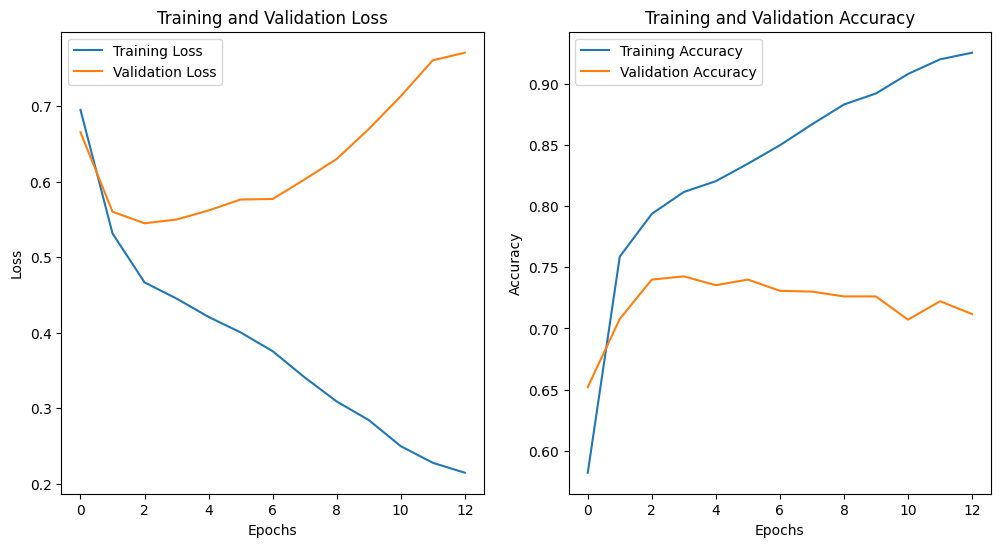

In [126]:
# Visualización de las métricas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2) # Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### 🟢 SVM

In [127]:
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(sentences)

X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [128]:
# Predicción y evaluación del modelo
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7708

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       874
           1       0.77      0.66      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



### Inciso 7. ✅ Clasificación de tweets

In [129]:
first_10_tweets = dataTest['text'].head(5).tolist()
first_10_sequences = tokenizer.texts_to_sequences(first_10_tweets)
first_10_padded = pad_sequences(first_10_sequences, maxlen=40, padding='post', truncating='post')
predictions = firstModel.predict(first_10_padded)
predictions2 = secondModel.predict(first_10_padded)
predictions3 = svm_model.predict(vectorizer.transform(first_10_tweets))

print("🔮 Predicciones del primer modelo:\n")
for i, prediction in enumerate(predictions):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction[0] > 0.5:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

print("🔮 Predicciones del segundo modelo:\n")
for i, prediction in enumerate(predictions2):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction[0] > 0.5:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

print("🔮 Predicciones del modelo SVM:\n")
for i, prediction in enumerate(predictions3):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction == 1:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔮 Predicciones del primer modelo:

Tweet: Just happened a terrible car crash
Predicción: Este tweet NO se refiere a un desastre.


Tweet: Heard about #earthquake is different cities, stay safe everyone.
Predicción: Este tweet se refiere a un desastre.


Tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicción: Este tweet se refiere a un desastre.


Tweet: Apocalypse lighting. #Spokane #wildfires
Predicción: Este tweet NO se refiere a un desastre.


Tweet: Typhoon Soudelor kills 28 in China and Taiwan
Predicción: Este tweet NO se refiere a un desastre.


🔮 Predicciones del segundo modelo:

Tweet: Just happened a terrible car crash
Predicción: Este tweet NO se refiere a un desastre.


Tweet: Heard about #earthquake is different cities, stay safe everyone.
Predicción: Este tweet se refiere a un desastre.


Tweet: ther

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


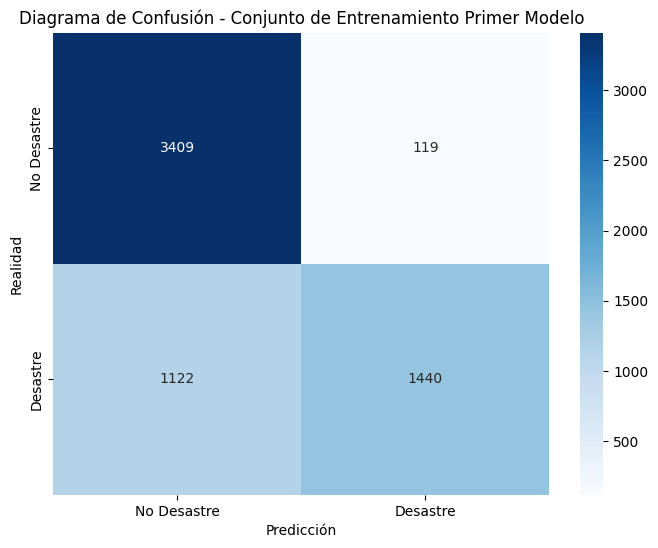

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


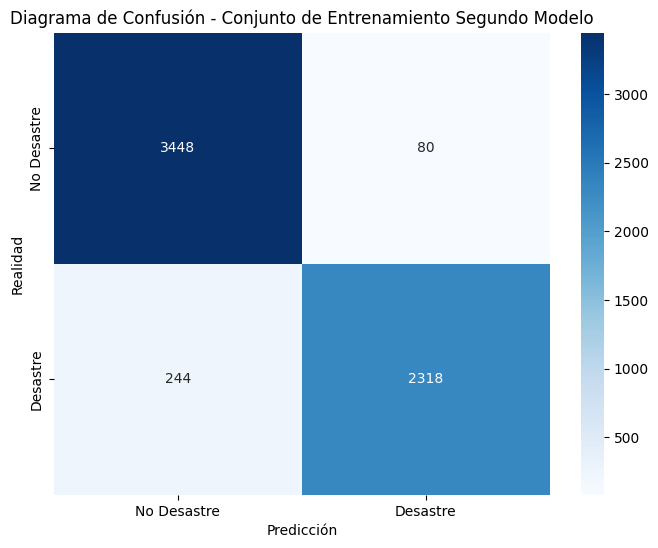

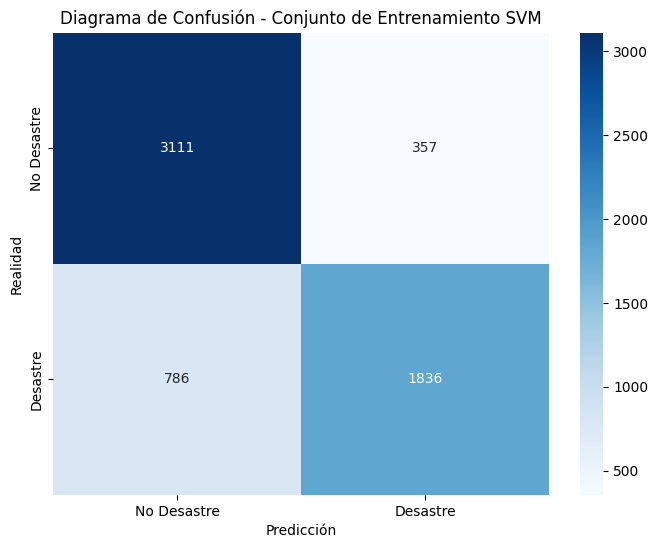

In [130]:
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
predictions_train = firstModel.predict(training_padded)
predictions_train = (predictions_train > 0.5).astype(int) 
true_labels_train = np.array(trainingTargets) 
cm_train = confusion_matrix(true_labels_train, predictions_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento Primer Modelo')
plt.show()

training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
predictions_train = secondModel.predict(training_padded)
predictions_train = (predictions_train > 0.5).astype(int) 
true_labels_train = np.array(trainingTargets) 
cm_train = confusion_matrix(true_labels_train, predictions_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento Segundo Modelo')
plt.show()

y_pred = svm_model.predict(X_train)
cm_train_svm = confusion_matrix(y_train, y_pred)

# Graficamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento SVM')
plt.show()